In [1]:
import os

import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt



In [52]:
random_seed = 0
torch.manual_seed(random_seed)

In [53]:
BATCH_SIZE = 128
DATA_DIR = "./MNIST_Fashion"

In [54]:
data = MNIST(DATA_DIR, train = True, download=True)
data_X = data.data.float()
data_Y = data.targets

In [55]:
class MNISTDataSet(Dataset):
	def __init__(self) -> None:
		xy = MNIST(DATA_DIR, train = True, download=True)
		self.x: torch.Tensor = xy.data.float()
		self.y: torch.Tensor = xy.targets
		self.n_samples = len(xy)
	
	def __getitem__(self, index):
		return self.x[index], self.y[index]
	
	def __len__(self):
		return self.n_samples

In [56]:
class Discriminator(nn.Module):
	def __init__(self, lr) -> None:
		super().__init__()

		self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
		self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
		
		self.conv2_drop = 	nn.Dropout2d()
		self.fc1 = nn.Linear(320, 50)
		self.fc2 = nn.Linear(50, 1)

		self.optimizer = optim.Adam(self.parameters(), lr)
	
	def forward(self, x: torch.Tensor):

		x = self.conv1(x)
		x = F.relu(F.max_pool2d(x, 2))
		x = self.conv2_drop(self.conv2(x))
		x = F.relu(F.max_pool2d(x, 2))

		x = x.view(-1, 320)

		x = F.relu(self.fc1(x))
		x = F.dropout(x, training=self.training)
		x = self.fc2(x)

		return torch.sigmoid(x)

In [57]:
class Generator(nn.Module):
	def __init__(self, latent_dim, lr) -> None:
		super().__init__()

		self.lin1 = nn.Linear(latent_dim, 7*7*64)
		self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
		self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
		self.conv = nn.Conv2d(16, 1, kernel_size=7)

		self.optimizer = optim.Adam(self.parameters(), lr)

	
	def forward(self, x: torch.Tensor):
		x = self.lin1(x)
		x = F.relu(x)

		x = x.view(-1, 64, 7, 7)

		x = self.ct1(x)
		x = F.relu(x)

		x = self.ct2(x)
		x = F.relu(x)

		return self.conv(x)

In [58]:
# output_size = floor((input_size-kernel_size+2*padding_size)/stride_size) + 1
 

class GAN:
	def __init__(self, batch_size = BATCH_SIZE, latent_dim = 100, lr = 0.0002) -> None:
		super().__init__()

		self.batch_size = batch_size
		self.latent_dim = latent_dim


		self.generator = Generator(latent_dim = latent_dim, lr=lr)
		self.discriminator = Discriminator(lr=lr)

		self.validation_z = torch.randn(6, latent_dim)
	
	
	def adversarial_loss(self, y_hat, y):
		return F.binary_cross_entropy(y_hat, y)	

	def training_generator(self, real_imgs, z):
		self.generator.optimizer.zero_grad()

		y_hat = self.discriminator(self.generator(z))

		y = torch.ones(real_imgs.shape[0], 1)
		y = y.type_as(real_imgs)

		loss = self.adversarial_loss(y_hat, y)

		loss.backward()

		self.generator.optimizer.step()

		return loss
	
	def training_discriminator(self, real_imgs: torch.Tensor, z):

		self.discriminator.optimizer.zero_grad()

		
		y_hat_real = self.discriminator(real_imgs.unsqueeze(1))

		y_real = torch.ones(real_imgs.shape[0], 1)
		y_real = y_real.type_as(real_imgs)

		real_loss = self.adversarial_loss(y_hat_real, y_real)

		y_hat_fake = self.discriminator(self.generator(z).detach())

		y_fake = torch.zeros(real_imgs.shape[0], 1)
		y_fake = y_fake.type_as(real_imgs)

		fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

		loss = (real_loss + fake_loss)/2



		loss.backward()

		self.discriminator.optimizer.step()

		return loss


	def training_step(self, real_imgs, generator):
		# samples noise

		z = torch.randn(real_imgs.shape[0], self.latent_dim)

		z = z.type_as(real_imgs)

		if generator:
			return self.training_generator(real_imgs, z)
		else:
			return self.training_discriminator(real_imgs, z)

	def fit(self, epochs: int, dataloader: DataLoader):
		for epoch in range(epochs):
			generator = False
			loss_generator = 0
			loss_discriminator = 0
			for i, (inputs, labels) in enumerate(dataloader):
				loss = self.training_step(inputs, generator)
				if generator:
					loss_generator += loss
				else:
					loss_discriminator += loss

				generator = not generator

			print("loss generator:", (2*loss_generator/(i+1)).detach().numpy())			
			print("loss discriminator:", (2*loss_discriminator/(i+1)).detach().numpy())

			self.plot_imgs(epoch)
	
	def generator_fit(self, epochs: int, dataloader: DataLoader):
		for epoch in range(epochs):
			total_loss = 0
			for i, (inputs, labels) in enumerate(dataloader):
				loss = self.training_step(inputs, True)

			print("loss generator:", (total_loss/(i+1)).detach().numpy())			

			self.plot_imgs(epoch)

	def plot_imgs(self, epoch):
		sample_imgs = self.generator(self.validation_z)


		print('epoch', epoch)

		fig = plt.figure()

		for i in range(sample_imgs.size(0)):
			plt.subplot(2, 3, i+1)
			plt.tight_layout()
			plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap = 'gray_r', interpolation='none')
			plt.title('Generated Data')
			plt.xticks([])
			plt.yticks([])
			plt.axis('off')
		
		plt.show()
	

In [59]:
model = GAN()

loss generator: 0.65431845
loss discriminator: 0.6727364
epoch 0


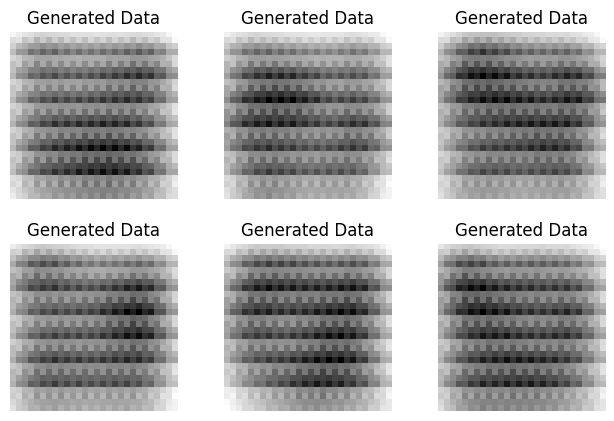

loss generator: 0.7940045
loss discriminator: 0.31400636
epoch 1


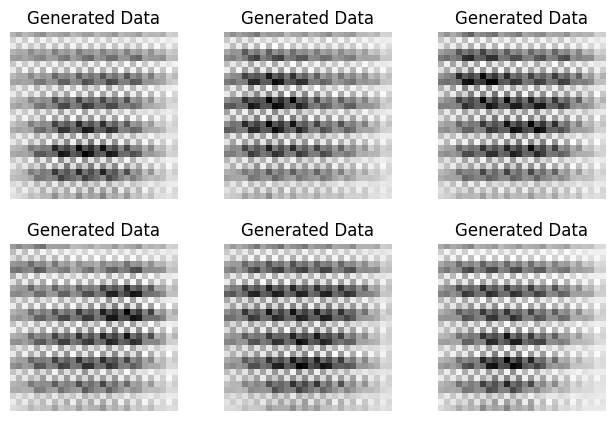

loss generator: 1.0224677
loss discriminator: 0.2379286
epoch 2


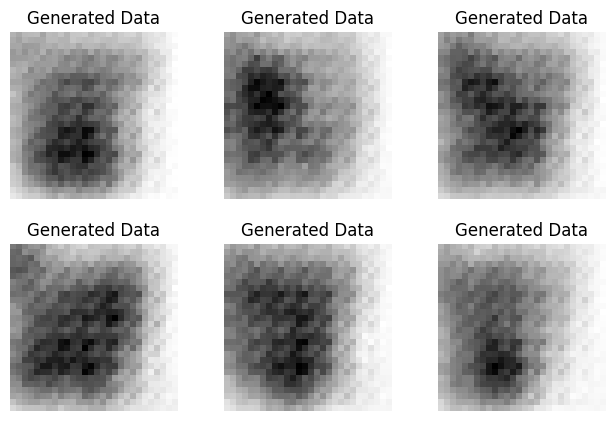

loss generator: 2.3685608
loss discriminator: 0.11317047
epoch 3


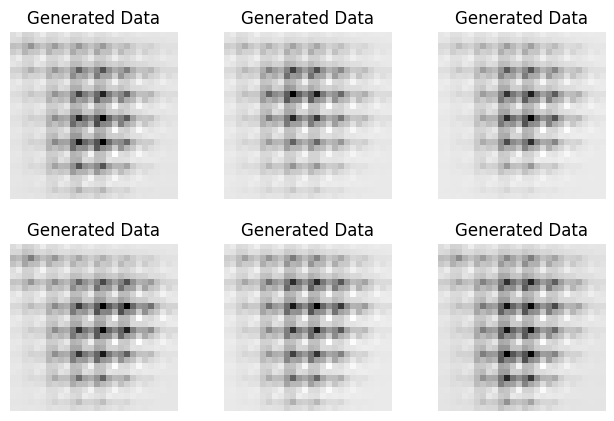

loss generator: 2.680542
loss discriminator: 0.10526107
epoch 4


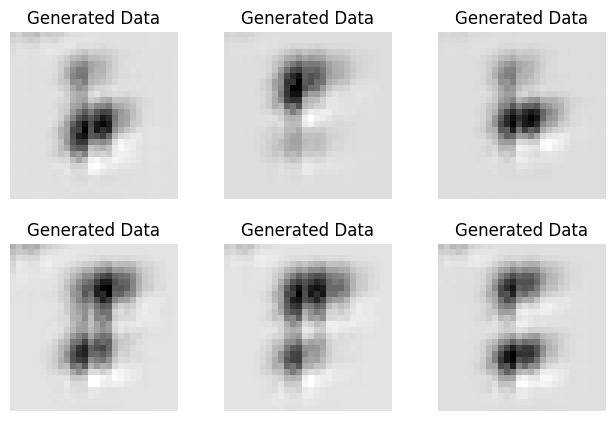

loss generator: 2.3579235
loss discriminator: 0.12523285
epoch 5


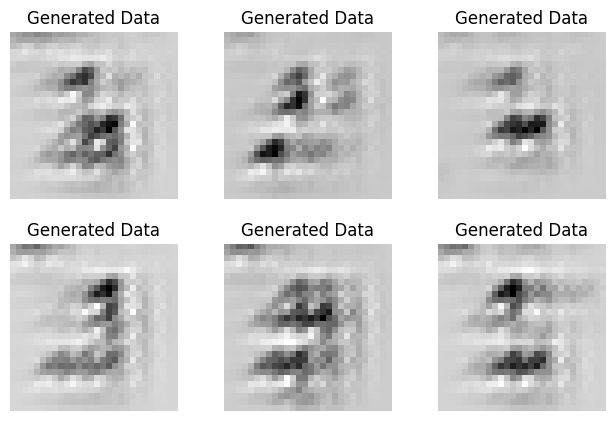

loss generator: 2.1855376
loss discriminator: 0.12512867
epoch 6


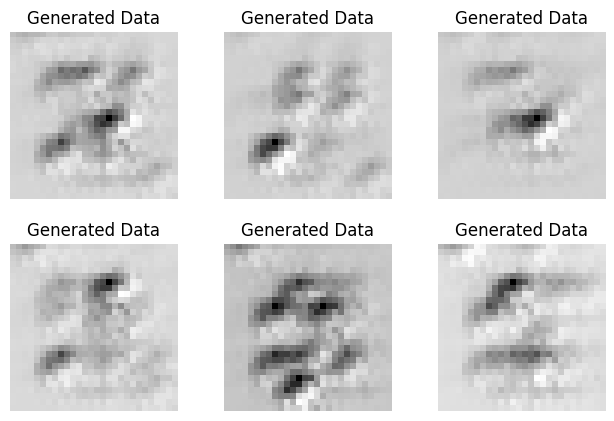

loss generator: 2.3499937
loss discriminator: 0.10165228
epoch 7


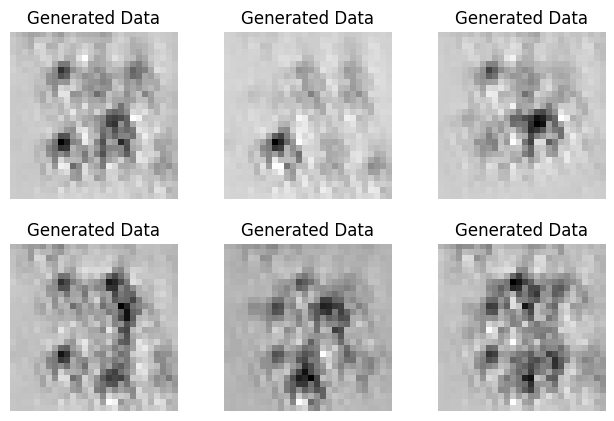

loss generator: 2.8606389
loss discriminator: 0.07184547
epoch 8


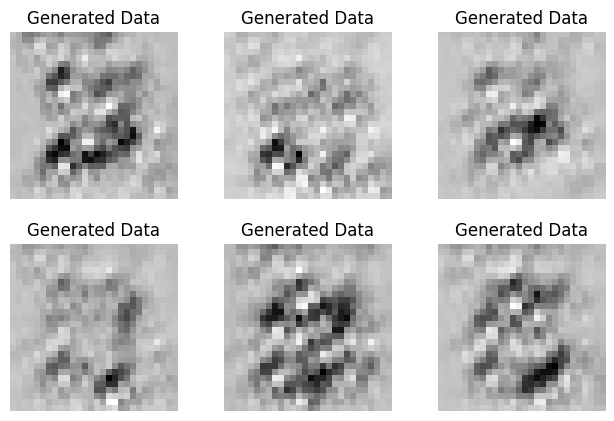

loss generator: 2.9487214
loss discriminator: 0.070823416
epoch 9


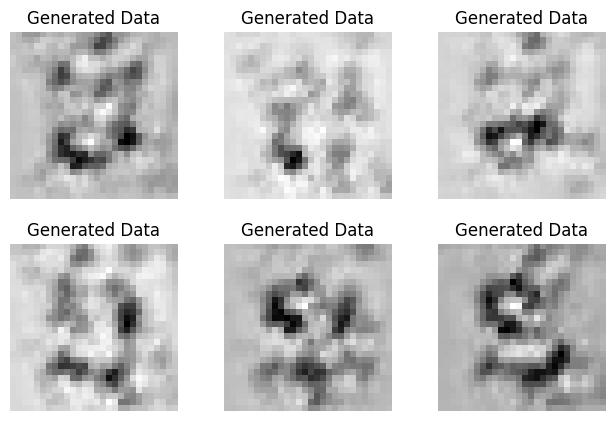

loss generator: 2.7938852
loss discriminator: 0.06606564
epoch 10


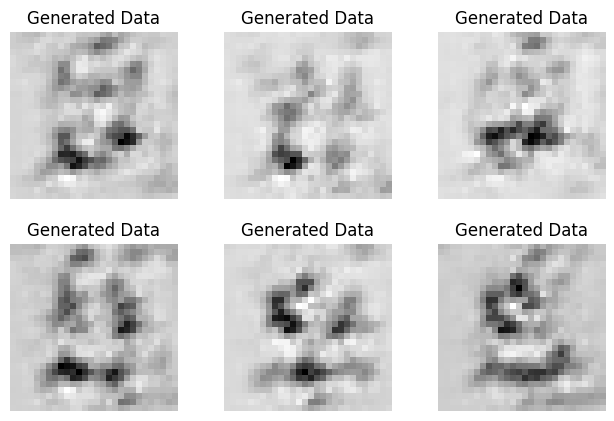

loss generator: 2.9197083
loss discriminator: 0.058342103
epoch 11


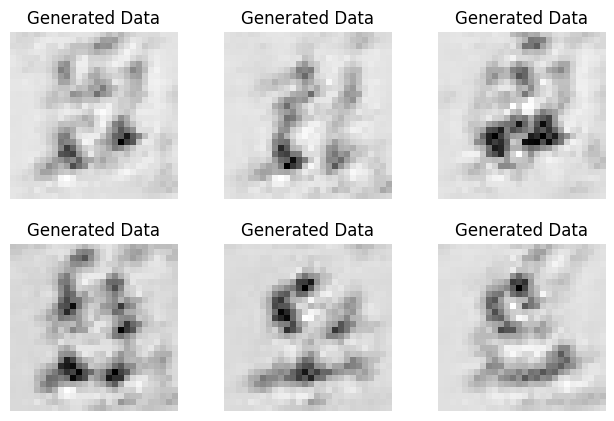

loss generator: 3.160338
loss discriminator: 0.05225336
epoch 12


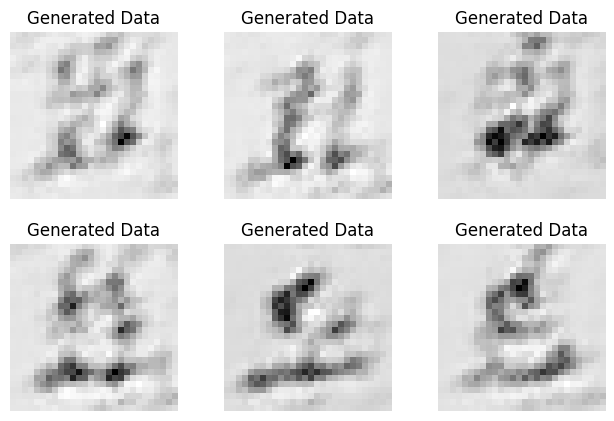

loss generator: 3.3198085
loss discriminator: 0.051668838
epoch 13


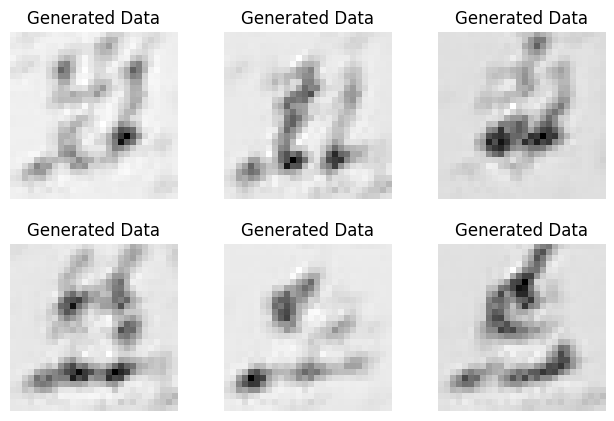

loss generator: 3.4202194
loss discriminator: 0.054957397
epoch 14


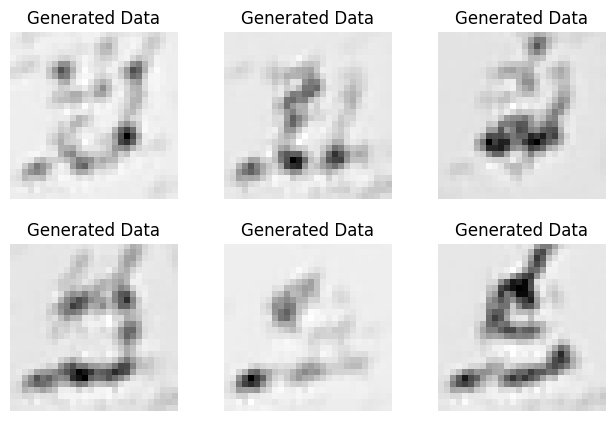

loss generator: 3.602052
loss discriminator: 0.055624258
epoch 15


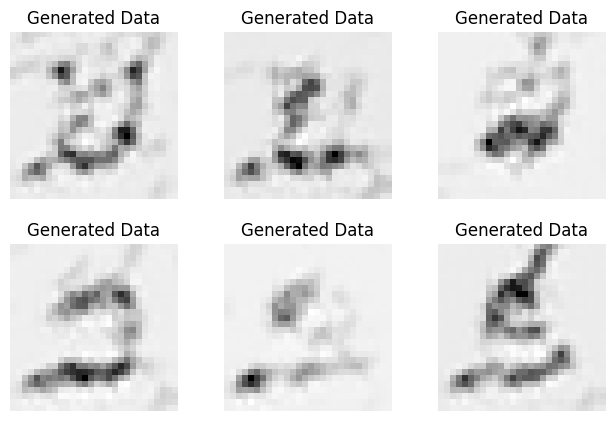

loss generator: 3.7793064
loss discriminator: 0.060397368
epoch 16


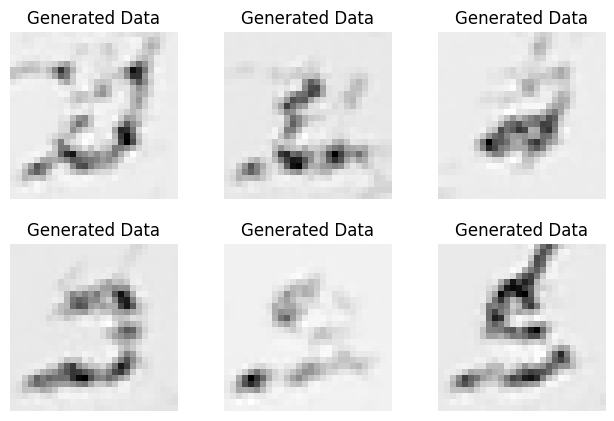

loss generator: 3.8530135
loss discriminator: 0.07181819
epoch 17


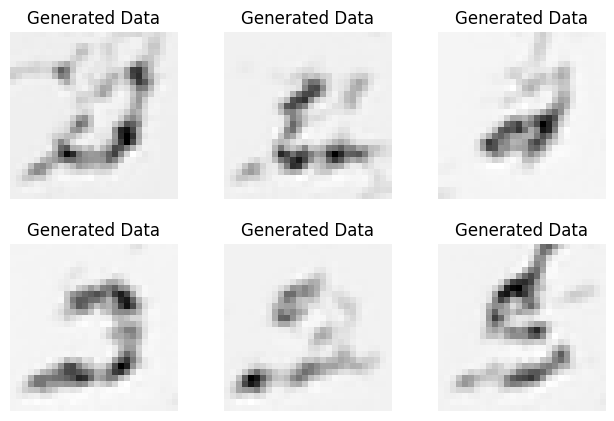

loss generator: 3.9919782
loss discriminator: 0.08506731
epoch 18


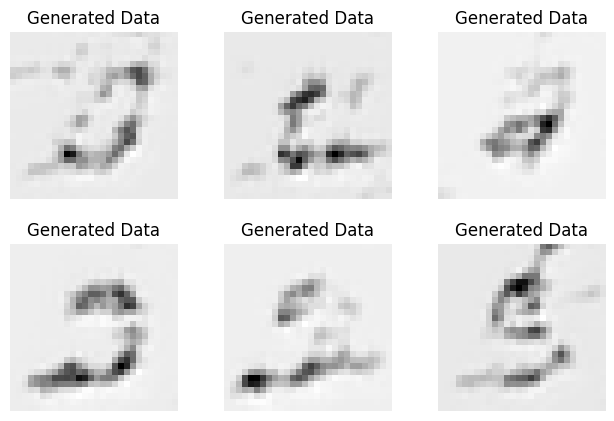

loss generator: 4.114266
loss discriminator: 0.09558167
epoch 19


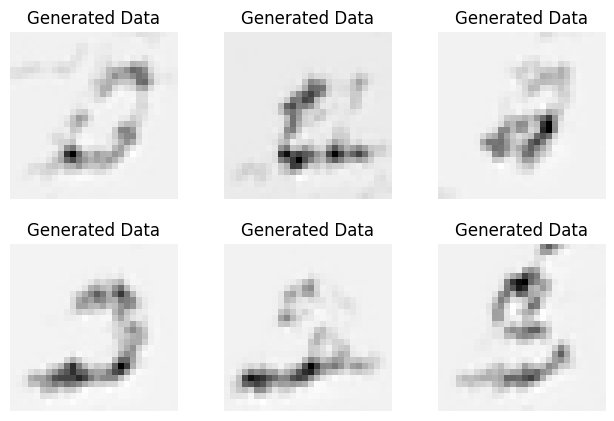

In [60]:
dataset = MNISTDataSet()
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle= True, num_workers=2)
model.fit(20, dataloader)

loss generator: 0.18056555
epoch 0


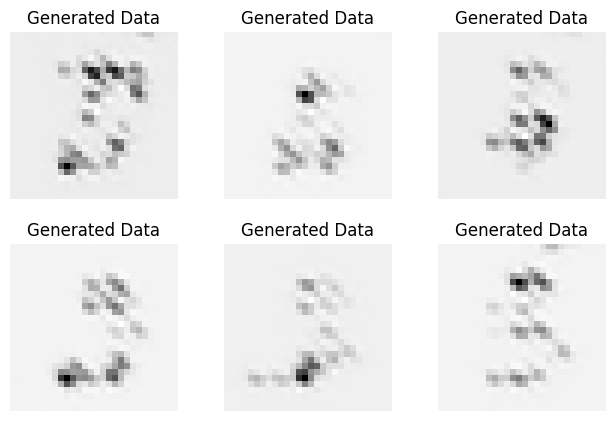

loss generator: 0.07556934
epoch 1


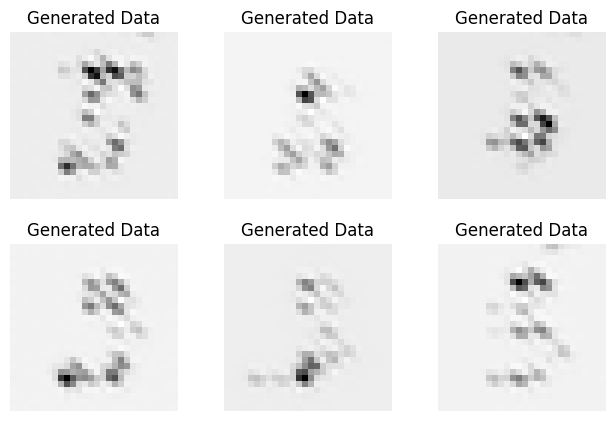

loss generator: 0.05013331
epoch 2


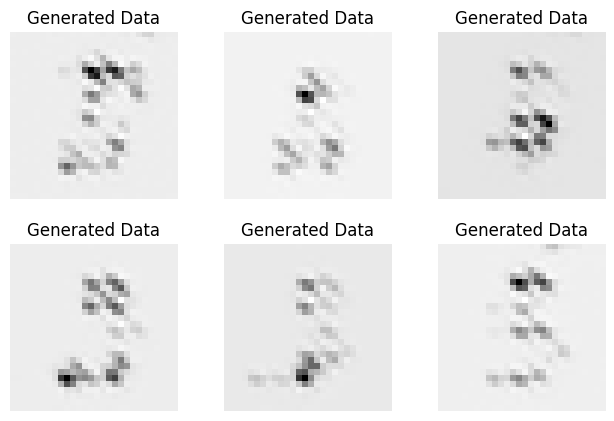

loss generator: 0.032280978
epoch 3


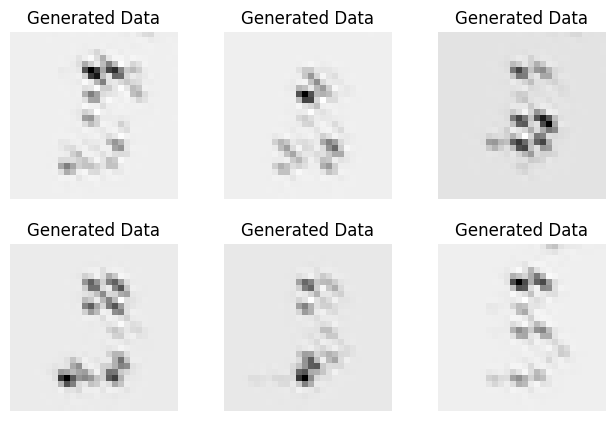

loss generator: 0.021251924
epoch 4


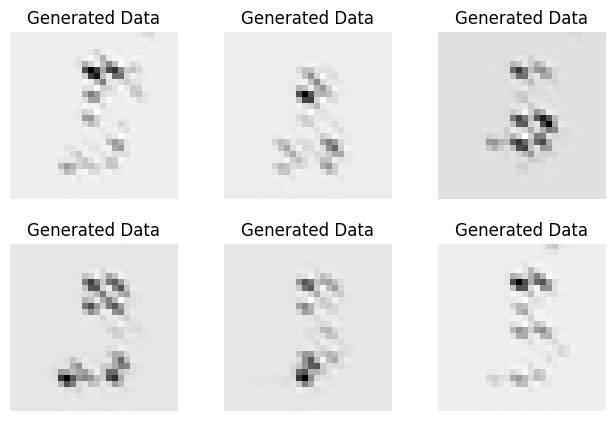

loss generator: 0.015462736
epoch 5


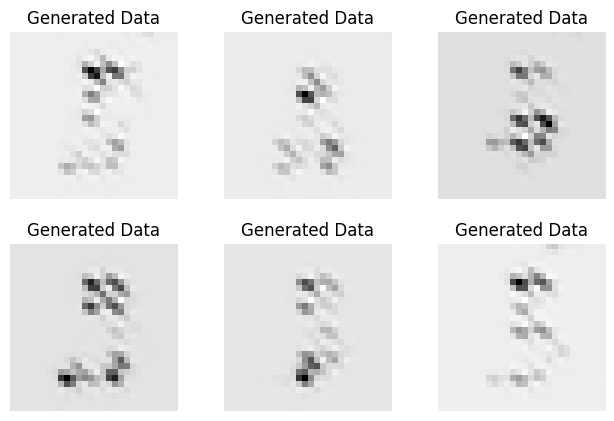

loss generator: 0.01292622
epoch 6


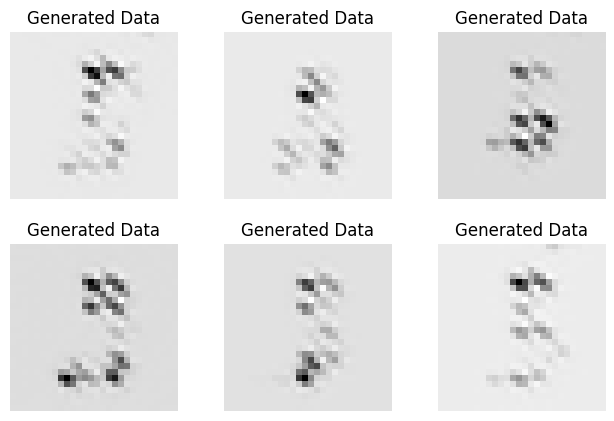

loss generator: 0.008969552
epoch 7


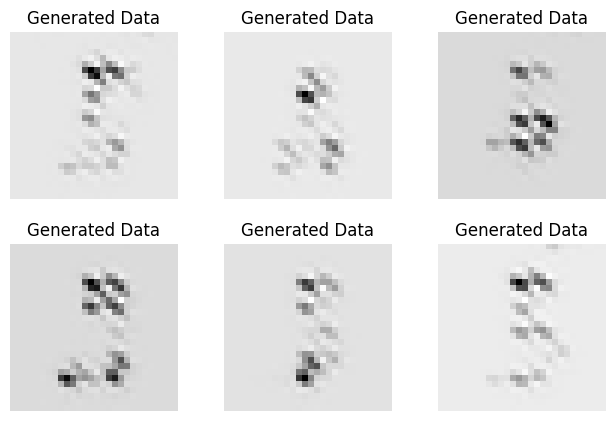

loss generator: 0.0070301387
epoch 8


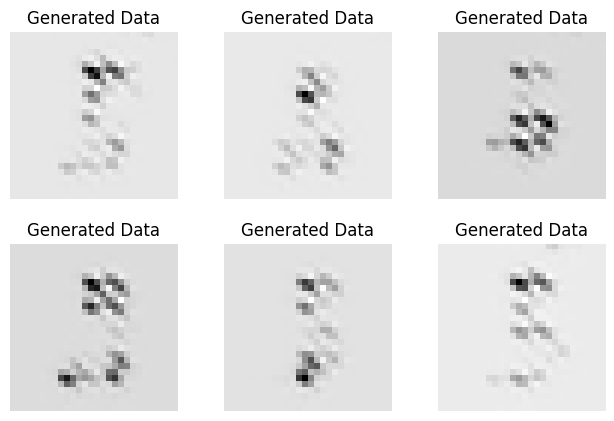

loss generator: 0.005907903
epoch 9


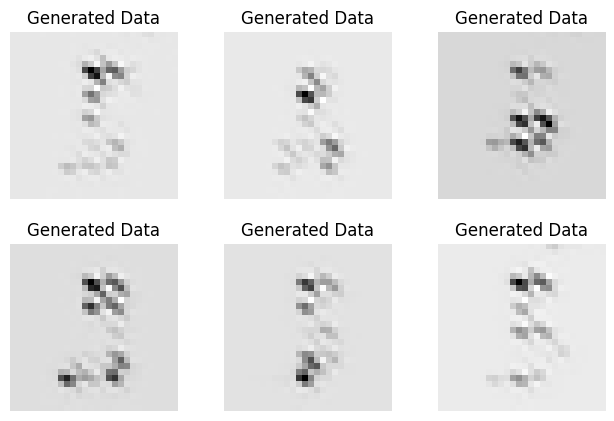

KeyboardInterrupt: 

In [63]:
epochs = 20

for epoch in range(epochs):
	total_loss = 0
	for i, (inputs, labels) in enumerate(dataloader):
		loss = model.training_step(inputs, True)
		total_loss += loss

	print("loss generator:", (total_loss/(i+1)).detach().numpy())			

	model.plot_imgs(epoch)